# Лабораторная работа №2

## Подключение библиотек

Подключим сторонние библиотеки:

- `numpy` для удобной работы с данными
- `matplotlib` для рисование графиков

In [28]:
import numpy as np
import matplotlib.pyplot as plt

Также подключим некоторые стандартные библиотеки

In [29]:
import math
from pprint import pprint
from collections import Counter
from typing import List, Union, Tuple

## Дополнительно 

Создадим функцию для более короткого представления массива из элементов np.float

In [30]:
def arr_to_str(arr: List[Union[np.float64, Tuple[np.float64, np.float64]]], digits: int = 4) -> str:
    def round_value(x):
        return round(float(x), digits)
    
    if arr and isinstance(arr[0], tuple):
        return str([(round_value(x), round_value(y)) for x, y in arr])
    else:
        return str([round_value(x) for x in arr])

## Импорт данных

Загрузим **файлы данных** и проверим корректно ли они загрузились

In [31]:
data_sets = []
for i in range(3):
    filename = f'set_{i + 1}.csv'
    try:
        cur_data = np.loadtxt(filename, delimiter=',')
        data_sets.append(cur_data)
    except FileNotFoundError:
        print(f"Ошибка: Файл {filename} не найден")
    except ValueError:
        print(f"Ошибка: Некорректный формат данных в файле {filename}")

SIZE = len(data_sets)
pprint(data_sets)

[array([3., 1., 1., ..., 1., 1., 3.], shape=(100000,)),
 array([ 90.547448,  80.548716,  92.992958, ...,   9.088514, 328.988096,
        84.872411], shape=(10000,)),
 array([0.002163, 0.023507, 0.067606, ..., 0.109763, 0.041012, 0.040421],
      shape=(100000,))]


## Обнаружение и удаления выбросов

Для удаления выбросов будем использовать медиану и медианное абсолютное отклонение (MAD). Напишем функцию реализующую это. Эта функция была написана еще при выполнении 1 лабораторной работы.

In [32]:
def remove_outliers_mad(data: np.ndarray, threshold: float = 3) -> np.ndarray:
    median = np.median(data)
    absolute_deviation = np.abs(data - median)
    
    mad = np.median(absolute_deviation)
    
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return filtered_data

Затем для каждого набора применим эту функцию.

In [33]:
for i in range(SIZE):
    data_sets[i] = remove_outliers_mad(data_sets[i])
pprint(data_sets)

[array([3., 1., 1., ..., 1., 1., 3.], shape=(82637,)),
 array([ 90.547448,  80.548716,  92.992958, ..., -47.738661,   9.088514,
        84.872411], shape=(9421,)),
 array([0.002163, 0.023507, 0.067606, ..., 0.109763, 0.041012, 0.040421],
      shape=(87395,))]


## Анализ данных

Выборочное математическое ожидание можем найти по следующей формуле:

$$\bar{x}_{B}=\frac{x_1+x_2+\ldots+x_n}{n}$$

А несмещенную (исправленную) дисперсию по следующей формуле:

$$s^2=\frac{1}{n-1}\sum_{i=1}^{n} (x_i - \bar{x}_{B})^2$$

In [34]:
def calculate_mean(data: np.ndarray) -> np.float64:    
    return sum(data) / len(data)


def calculate_unbiased_variance(data: np.ndarray, mean: np.float64 | None = None) -> np.float64:
    if mean is None:
        mean = calculate_mean(data)
    return 1 / (len(data) - 1) * sum((data[i] - mean) ** 2 for i in range(len(data))) 

Посчитаем $\bar{x}_B$, а также $s^2$ для каждого набора данных

In [35]:
means = [calculate_mean(data_sets[i]) for i in range(SIZE)]
unbiased_variances = [calculate_unbiased_variance(data_sets[i], means[i]) for i in range(SIZE)]

print("Выборочное мат. ожидание:", arr_to_str(means))
print("Выборочная несмещенная дисперсия:", arr_to_str(unbiased_variances))

Выборочное мат. ожидание: [2.3274, 18.8716, 0.0889]
Выборочная несмещенная дисперсия: [1.7105, 5684.5198, 0.0048]


## Построение доверительных интервалов

Сначала нужно построить таблицу критических точек распределения Стьюдента ($t$-распределения). Построю её, например, для уровня значимости $\alpha=0.1$

In [36]:
ALPHA = 0.1

def _get_t_table():
    t_table = {
        1: 6.31, 2: 2.92, 3: 2.35, 4: 2.13, 5: 2.01,
        6: 1.94, 7: 1.89, 8: 1.86, 9: 1.83, 10: 1.81,
        11: 1.80, 12: 1.78, 13: 1.77, 14: 1.76, 15: 1.75,
        16: 1.75, 17: 1.74, 18: 1.73, 19: 1.73, 20: 1.73,
        21: 1.72, 22: 1.72, 23: 1.71, 24: 1.71, 25: 1.71,
        26: 1.71, 27: 1.71, 28: 1.70, 29: 1.70, 30: 1.70,
        40: 1.68, 60: 1.67, 120: 1.66, float('inf'): 1.64,
    }

    def wrapper(n: int) -> float:
        if n in t_table:
            return t_table[n]
        
        if n > 120:
            return 1.66 - (1.66 - 1.64) * min((n - 120) / 10000, 1)
        
        lower_n = max(k for k in t_table if k < n)
        upper_n = min(k for k in t_table if k > n)
        
        lower_val = t_table[lower_n]
        upper_val = t_table[upper_n]
        
        ratio = (n - lower_n) / (upper_n - lower_n)
        return lower_val + ratio * (upper_val - lower_val)
    return wrapper


t = _get_t_table()

### Доверительный интервал для математического ожидания

Теперь найдем доверительный интервал для математического ожидания, в предположении, что у нас данные подчиняются нормальному распределению.

Искомый интервал $(\underline{\theta}, \overline{\theta})$ ищется по формулам:
$$\underline{\theta}=\bar{x}_B - \frac{t_{n-1} \cdot s}{\sqrt{n}}$$

$$\overline{\theta}=\bar{x}_B + \frac{t_{n-1} \cdot s}{\sqrt{n}}$$

In [37]:
def get_mean_interval(mean: np.float64, s: np.float64, n: int):
    part = t(n - 1) * s / np.sqrt(n)
    return ((mean - part), (mean + part))

Рассчитаем искомые интервалы математического ожидания для каждого набора данных.

In [38]:
mean_intervals = [
    get_mean_interval(means[i], np.sqrt(unbiased_variances[i]), len(data_sets[i]))
    for i in range(SIZE)
]

print(arr_to_str(mean_intervals))

[(2.3199, 2.3348), (17.5965, 20.1466), (0.0885, 0.0893)]


### Доверительный интервал для дисперсии

Доверительный интервал $(\underline{\theta}, \overline{\theta})$ для дисперсии можно построить по формулам:

$$\underline{\theta} = \frac{(n-1) \cdot s^2}{\chi^2_{1-\frac{\alpha}{2}, n-1}}$$

$$\overline{\theta} = \frac{(n-1) \cdot s^2}{\chi^2_{\frac{\alpha}{2}, n-1}}$$

По этим форммулам понятно, что нужно каким-то образом получить критические точки распределения $\chi^2$. Решим эту проблему с помощью **аппроксимации Корниша-Фишера**.

$$\chi^2_{\alpha, n} \approx n + A \sqrt{n} + B + \frac{C}{\sqrt{n}} + \frac{D}{n} + \frac{E}{n\sqrt{n}}$$

где:

$A = d \sqrt{2}$

$B = \frac{2}{3} (d^2 - 1)$

$C = d \cdot \frac{d^2 - 7}{9\sqrt{2}}$

$D = \frac{6d^4+14d^2-32}{405}$

$E = d \cdot \frac{9d^4 + 256d^2 - 433}{4860\sqrt{2}}$

$d = \Phi^{-1}(\alpha) \approx
\begin{cases}
2.0637 \left( \ln{\frac{1}{1-\alpha}} - 0.16 \right)^{0.4274} - 1.5774, \quad 0.5 \leq \alpha \leq 0.999\\
-2.0637 \left( \ln{\frac{1}{\alpha}} - 0.16 \right)^{0.4274} + 1.5774, \quad 0.001 \leq \alpha < 0.5
\end{cases}
$
<!--аппроксимация Уилсона-Хилферти --> 

In [39]:
def chi(alpha: float, n: int):
    if 0.5 <= alpha < 1:
        d = 2.0637 * math.pow((math.log(1 / ( 1 - alpha)) - 0.16), 0.4274) - 1.5774
    else:
        d = -2.0637 * math.pow((math.log(1 / alpha) - 0.16), 0.4274) + 1.5774
    A = d * math.sqrt(2)
    B = 2 / 3 * (d ** 2 - 1)
    C = d * (d ** 2 - 7) / (9 * math.sqrt(2))
    D = (6 * d ** 4 + 14 * d ** 2 - 32) / 405
    E = d * (9 * d ** 4 + 256 * d ** 2 - 433) / (4860 * math.sqrt(2))
    sqrt_n = math.sqrt(n)
    return n + A * sqrt_n + B + C / sqrt_n + D / n + E / (n * sqrt_n)


Теперь найдем доверительные интервалы для дисперсии для каждого набора данных.

In [40]:
def get_variance_interval(unbiased_variance: np.float64, alpha: int, n: int):
    return ((n - 1) * unbiased_variance / chi(1 - alpha / 2, n), 
            (n - 1) * unbiased_variance / chi(alpha / 2, n))


variance_intervals = [
    get_variance_interval(unbiased_variances[i], ALPHA, len(data_sets[i]))
    for i in range(SIZE)
]

print(arr_to_str(variance_intervals))

[(1.6967, 1.7244), (5550.2598, 5822.7298), (0.0047, 0.0048)]


## Генерация теоретических распределений

Так как функции для генерации теоретических распредлений я написал еще при выполнении 1 лабы, то код возьму оттуда и вставлю сюда. 

In [41]:
def geometric_distribution(mean: float, size: int) -> np.ndarray | None:
    p = 1 / mean
    if p > 1:
        return None
    log_q = np.log(1 - p)
    u = random_uniform(0, 1, size)
    random_numbers = np.ceil(np.log(1 - u) / log_q)
    return random_numbers


def random_uniform(low: float, high: float, size: int) -> np.ndarray:
    random_numbers = [low + (high - low) * np.random.rand() for _ in range(size)]
    return np.array(random_numbers)


def uniform_distribution(mean: float, variance: float, size: int) -> np.ndarray:
    low = mean - np.sqrt(3 * variance)
    high = mean + np.sqrt(3 * variance)

    return random_uniform(low, high, size)


def box_muller():
    u1 = np.random.rand()
    u2 = np.random.rand()
    
    r = np.sqrt(-2 * np.log(1 - u1))
    theta = 2 * np.pi * u2

    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def normal_distribution(mean: float, variance: float, size: int) -> np.ndarray:
    std_dev = np.sqrt(variance)
    random_numbers = np.zeros(size)

    for i in range(size // 2):
        x, y = box_muller()

        random_numbers[2*i] = x * std_dev + mean
        random_numbers[2*i + 1] = y * std_dev + mean
    
    if size % 2 != 0:
        x, y = box_muller()
        random_numbers[-1] = x * std_dev + mean
    return random_numbers


def exponential_distribution(mean: float, size: int):
    u = random_uniform(0, 1, size)
    random_numbers = -mean * np.log(1 - u)
    return random_numbers


def poisson_distribution(lam: float, size: int) -> np.ndarray:
    random_numbers = np.zeros(size)
    L = np.exp(-lam)
    
    for i in range(size):
        u = np.random.rand()
        k = 0
        cur_term = 1
        sum = cur_term
        while L * sum < u:
            k += 1
            cur_term *= lam / k
            sum += cur_term
        
        random_numbers[i] = k
    
    return random_numbers

Возьму также с 1 лабы функцию, которая рисует диаграммы

In [42]:
def plot_histograms(numbers: np.ndarray, title: str):
    counter = Counter(numbers)
    if len(counter) < 19:
        bins = np.arange(np.min(numbers), np.max(numbers) + 2)
    else:
        bins = 20
    plt.hist(numbers, bins=bins, density=True, alpha=0.6, color='green',
             edgecolor='black', linewidth=1.5)
    
    plt.title(title)
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.grid()
    plt.show()

Построим гистограммы для заданных наборов данных

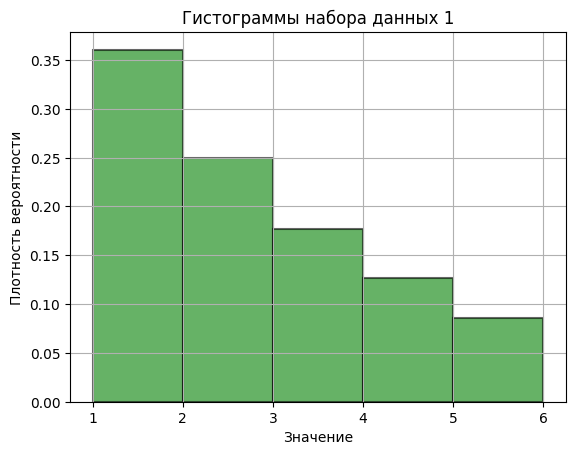

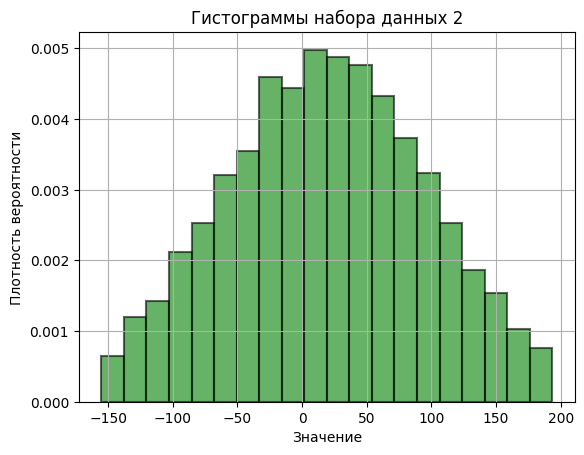

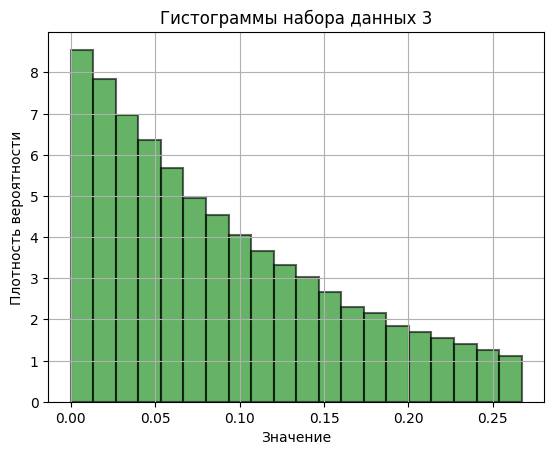

In [43]:
for i, cur_data in enumerate(data_sets):
    plot_histograms(cur_data, f'Гистограммы набора данных {i + 1}')

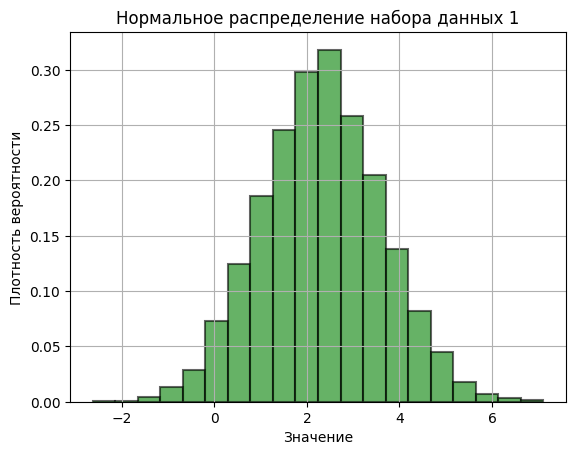

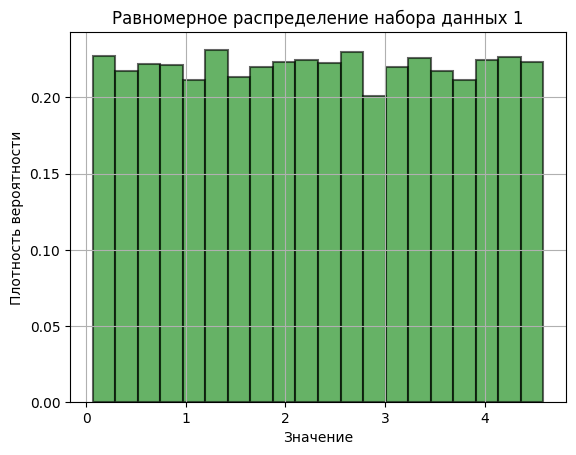

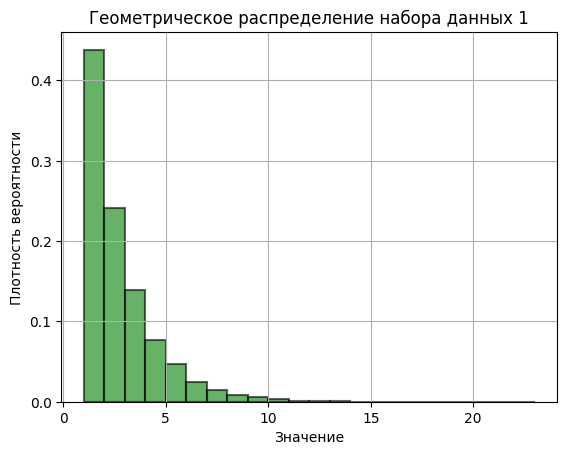

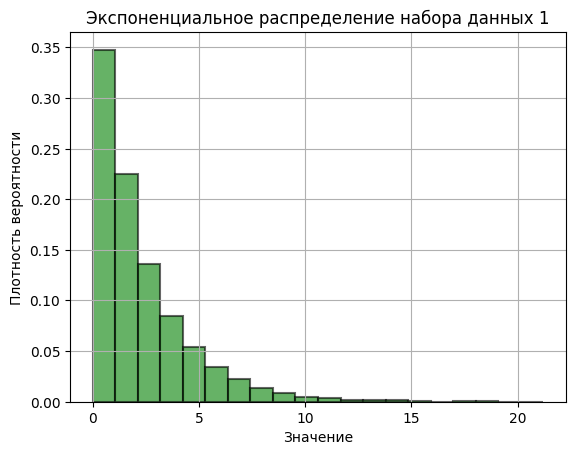

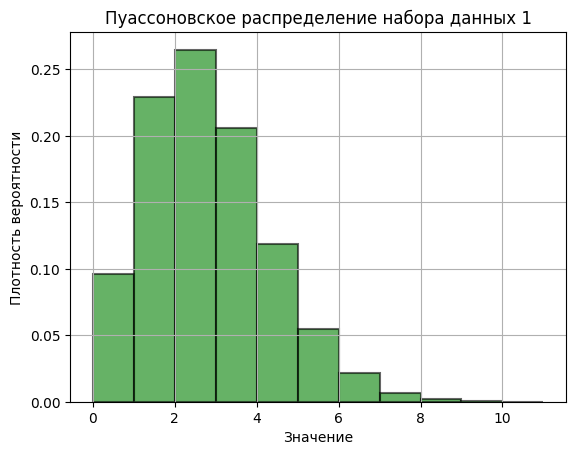

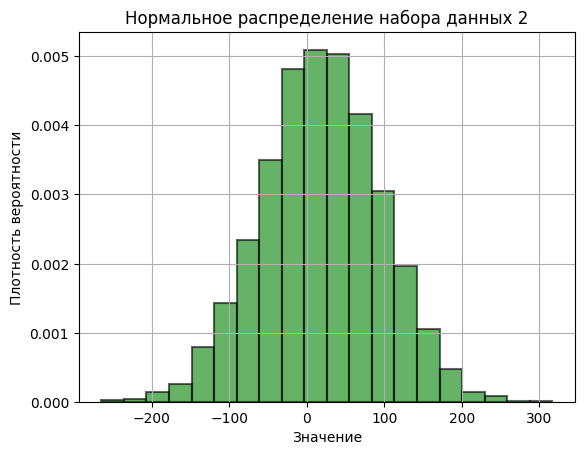

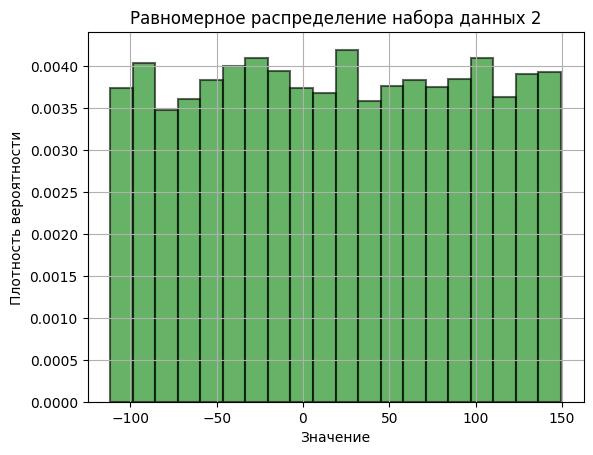

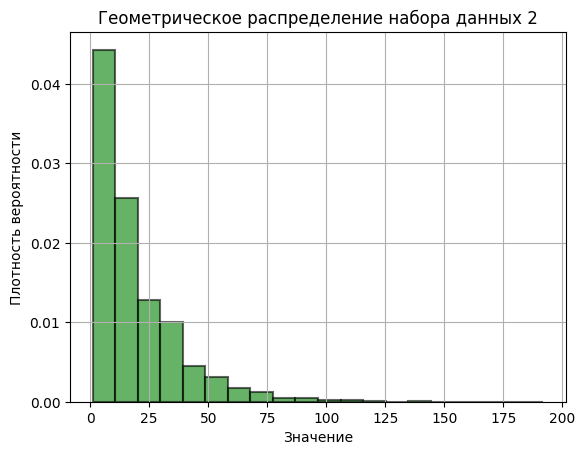

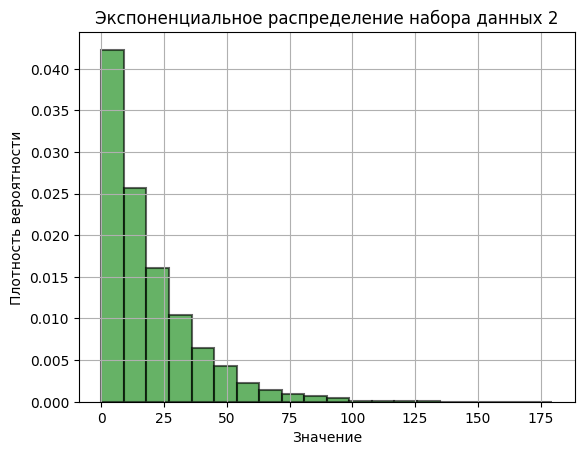

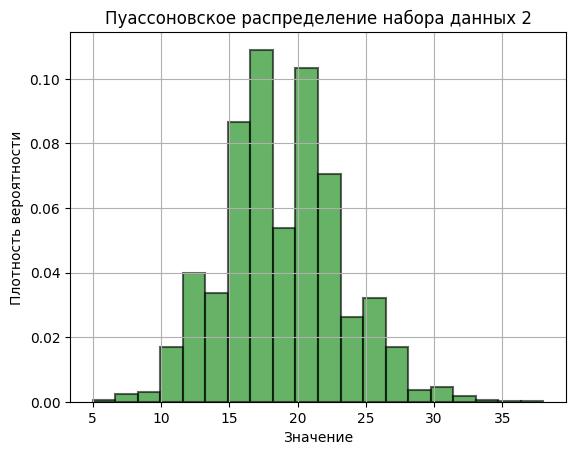

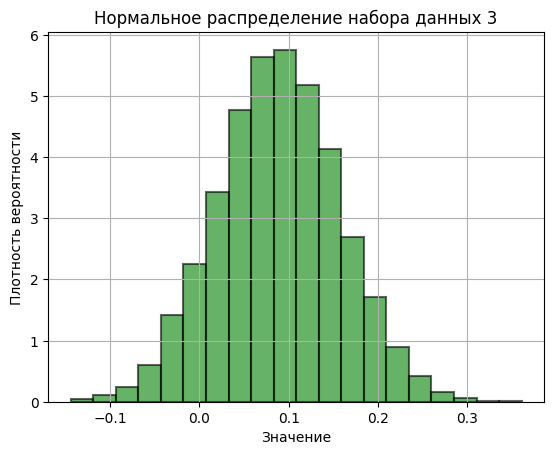

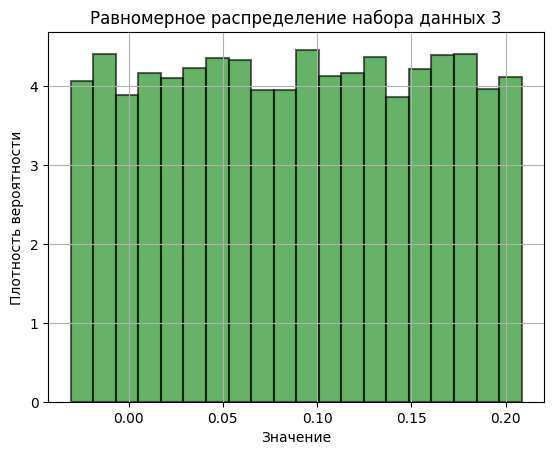

Геометрическое распределение не может быть построено с заданным параметром математического
ожидания. Посколько вероятность успешного события в таком случае больше 1 (11.25108596667415)


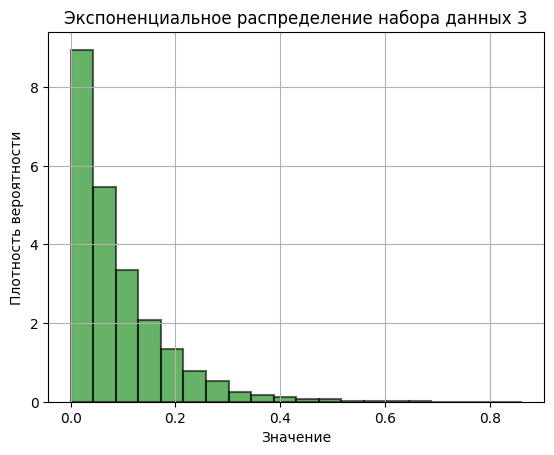

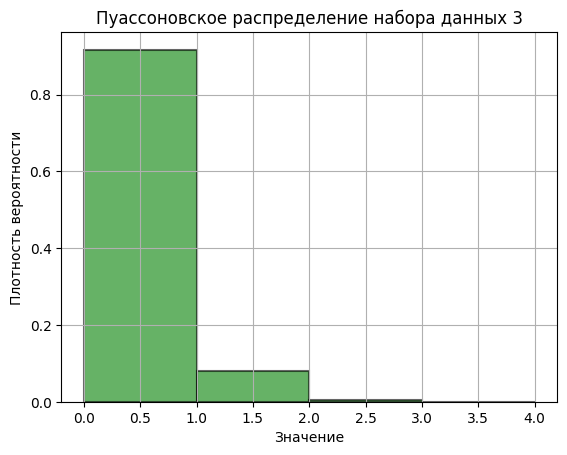

In [44]:
SAMPLE_SIZE = 10000

for i in range(SIZE):
    norm_distribution = normal_distribution(means[i], unbiased_variances[i], SAMPLE_SIZE)
    uni_distribution = uniform_distribution(means[i], unbiased_variances[i], SAMPLE_SIZE)
    geo_distribution = geometric_distribution(means[i], SAMPLE_SIZE)
    exp_distribution = exponential_distribution(means[i], SAMPLE_SIZE)
    pois_distribution = poisson_distribution(means[i], SAMPLE_SIZE)

    plot_histograms(norm_distribution, f"Нормальное распределение набора данных {i + 1}")
    plot_histograms(uni_distribution, f"Равномерное распределение набора данных {i + 1}")
    if geo_distribution is None:
        print("Геометрическое распределение не может быть построено с заданным параметром математического")
        print(f"ожидания. Посколько вероятность успешного события в таком случае больше 1 ({1 / means[i]})")
    else:
        plot_histograms(geo_distribution, f"Геометрическое распределение набора данных {i + 1}")
    plot_histograms(exp_distribution, f"Экспоненциальное распределение набора данных {i + 1}")
    plot_histograms(pois_distribution, f"Пуассоновское распределение набора данных {i + 1}")

Возьмем функцию из 1 лабы, которая рисует две гистограммы на одном холсте

In [45]:
def plot_theoretical_and_empirical_histogram(
        empirical_data: np.ndarray,
        theoretical_data: np.ndarray,
        title: str
    ):
    counter_empirical = Counter(empirical_data)
    counter_theoretical = Counter(theoretical_data)

    min_val = min(np.min(empirical_data), np.min(theoretical_data))
    max_val = max(np.max(empirical_data), np.max(theoretical_data))

    if len(counter_empirical) < 15 or len(counter_theoretical) < 15:
        bins = np.arange(min_val, max_val + 2)
    else:
        bins = 20
    
    plt.hist(empirical_data, bins=bins, density=True, alpha=0.6, color='yellow',
             edgecolor='black', linewidth=1.5, label="Эмпирические данные")
    
    plt.hist(theoretical_data, bins=bins, density=True, alpha=0.6, color='blue',
             edgecolor='black', linewidth=1.5, label="Теоретическая модель")

    plt.title(title)
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.grid(True)
    plt.legend()
    plt.show()

Первый набор данных похож на геометрическое и на экспоненциальное распределения. Давайте сравним этот набор данных с его теоретическими моделями

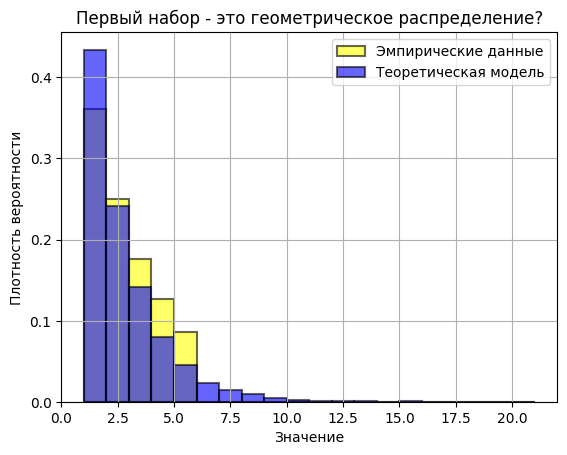

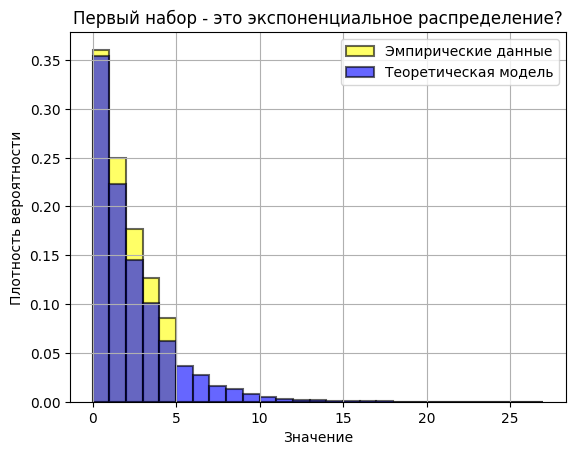

In [47]:
theor_geo_distribution = geometric_distribution(means[0], SAMPLE_SIZE)
plot_theoretical_and_empirical_histogram(
    data_sets[0],
    theor_geo_distribution,
    "Первый набор - это геометрическое распределение?"
)

theor_exp_distribution = exponential_distribution(means[0], SAMPLE_SIZE)
plot_theoretical_and_empirical_histogram(
    data_sets[0],
    theor_exp_distribution,
    "Первый набор - это экспоненциальное распределение?"
)

Исходя из данных графиков я делаю вывод, что первый набор данных подчиняется экспоненциальному закону распределения.

Второй набор данных больше всего напоминает нормальное распределение. Давайте это проверим, сравнив теоретическое распределение с гистограммой.

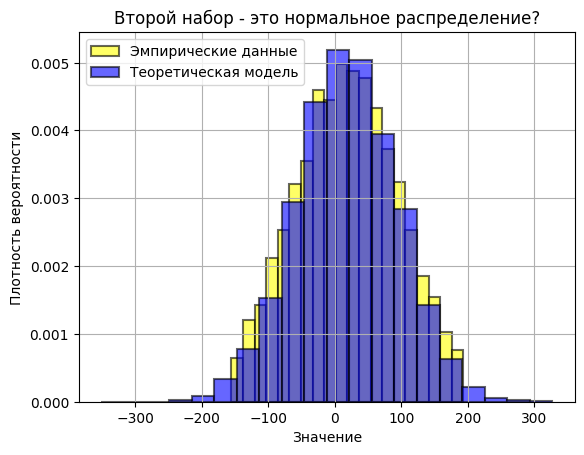

In [48]:
theor_norm_distribution = normal_distribution(means[1], unbiased_variances[1], SAMPLE_SIZE)
plot_theoretical_and_empirical_histogram(
    data_sets[1],
    theor_norm_distribution,
    "Второй набор - это нормальное распределение?"
)

Действительно, второй набор подчиняется нормальному распределению.


Третий набор данных напоминает экспоненциальное распределение. Проверим это.

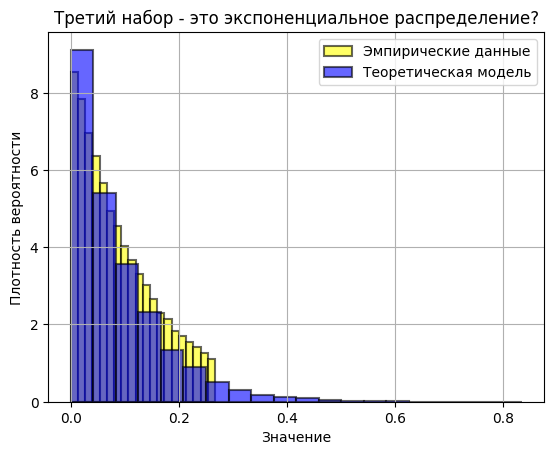

In [49]:
theor_exp_distribution = exponential_distribution(means[2], SAMPLE_SIZE)
plot_theoretical_and_empirical_histogram(
    data_sets[2],
    theor_exp_distribution,
    "Третий набор - это экспоненциальное распределение?"
)

Действительно, третий набор подчиняется экспоненциальному распределению.

Итого имеем:

|Набор данных|Распределение|
|-|-|
|1|Экспоненциальное|
|2|Нормальное|
|3|Экспоненциальное|

## Проверка гипотез